1. Importing the necessary python libraries for training, testing and evaluation of model:

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # hide warning messages

import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input, MaxPooling2D, Conv2D
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomContrast, RandomZoom, RandomTranslation
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
import random
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import pylab as pl

2. Loading the training images from folder and putting them in the pandas dataframe. We have 5712 images for training and they are categorised into 4 classes (given in the output of the below cell with the corresponding integer mapping):

In [2]:
path_train = 'Training/'  # main folder containing the subfolders for different types
train_dictionary = {"image_path":[],"target":[]}
type = 0
for i in os.listdir(path_train):
    train_img = path_train+i+'/'  # appending the subfolder path
    if(os.path.isdir(train_img)):
        for j in os.listdir(train_img):
            train_dictionary["image_path"].append(train_img+j)
            train_dictionary["target"].append(type)  # the integer 'type' is used as target variable
        print(i, ":", type)  # assigning a unique integer mapping to each type of tumor
        type += 1
train = pd.DataFrame(train_dictionary)
train.info()

pituitary : 0
notumor : 1
glioma : 2
meningioma : 3
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5712 entries, 0 to 5711
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  5712 non-null   object
 1   target      5712 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 89.4+ KB


3. Loading the testing images from folder and putting them in the pandas dataframe. We have almost 1311 images for testing in the same format as the training images:

In [3]:
path_test = 'Testing/'
test_dictionary = {"image_path":[],"target":[]}
type = 0
for i in os.listdir(path_test):
    test_img = path_test+i+'/'
    if(os.path.isdir(test_img)):
        for j in os.listdir(test_img):
            test_dictionary["image_path"].append(test_img+j)
            test_dictionary["target"].append(type)
        print(i, ":", type)
        type += 1
test = pd.DataFrame(test_dictionary)
test.info()

pituitary : 0
notumor : 1
glioma : 2
meningioma : 3
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1311 entries, 0 to 1310
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  1311 non-null   object
 1   target      1311 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 20.6+ KB


4. Defining the Data Augmentation function with parameters to set random image properties:

In [4]:
with tf.device('/cpu:0'):
    data_augmentation = Sequential([
        RandomFlip("horizontal"),
        RandomRotation(0.02, fill_mode='constant'),
        RandomContrast(0.1),
        RandomZoom(height_factor=0.01, width_factor=0.05),
        RandomTranslation(height_factor=0.0015, width_factor=0.0015, fill_mode='constant'),
    ])

Metal device set to: Apple M2


5. Converting the loaded images in the pandas train dataframe to grayscale numpy array with proper resizing and performing data augmentation once per image. Hence the train input and target label of the model is created:

In [5]:
images = []  # numpy array contaning floating point pixel values of the training images
for i in train["image_path"]:
    img = cv2.imread(i, cv2.IMREAD_GRAYSCALE)  # converting the RBG values to Grayscale to decrease dimensions of redundant data
    img = cv2.resize(img,(168,168))  # resizing properly to compensate for the inconsistent dimensions of the images
    img = np.expand_dims(img, axis=-1)  # adding an extra dimension to make it (168, 168, 1)
    img_aug = data_augmentation(img)  # performing random augmentation once
    img = img / 255.0  
    img_aug = img_aug / 255.0
    images.append(img)
    images.append(img_aug)
label = []
label = train["target"]
x_train = np.array(images)
label = np.array(label)
label = np.repeat(label,2)  # compensate for the augmentation
y_train = keras.utils.to_categorical(label, 4)  # convert to one-hot encoded target label
print(x_train.shape)
print(np.sum(y_train, axis=0))

(11424, 168, 168, 1)
[2914. 3190. 2642. 2678.]


6. Performing the same thing for the testing images but without augmentation since validation data is not augmented. Also we see in the previous output that the training dataset is not skewed so there is no need for any further data augmentation:

In [6]:
images = []
for i in test["image_path"]:
    img = cv2.imread(i, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img,(168,168))
    img = np.expand_dims(img, axis=-1)
    img = img / 255.0
    images.append(img)
label = []
label = test["target"]
x_test = np.array(images)
label = np.array(label)
y_test = keras.utils.to_categorical(label, 4)
print(x_test.shape)
print(np.sum(y_test, axis=0))

(1311, 168, 168, 1)
[300. 405. 300. 306.]


7. Pre-trained state-of-the-art CNNs like VGG19, InceptionV3 or Xception were found to underfit the data due to their huge number of layers which was not necessary and yielded a validation accuracy of around 90-93%. Also it is computationally more expensive to load models having 100MB+ sizes due to RAM limitation on server. Hence the following custom CNN model was used which gives a validation accuracy of 97%:

In [7]:
model = Sequential([
    Input(shape=(168,168,1)),
    # 4 Convolutional + MaxPooling layers
    Conv2D(64, (5, 5), activation="relu"),
    MaxPooling2D(pool_size=(3, 3)),
    Conv2D(64, (5, 5), activation="relu"),
    MaxPooling2D(pool_size=(3, 3)),
    Conv2D(128, (4, 4), activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (4, 4), activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    # 2 Dense + Dropout layers to prevent overfitting
    Dense(512, activation="relu"),
    Dropout(0.4),
    Dense(64, activation="relu"),
    Dropout(0.25),
    # Finally 1 Dense layer which num_classes = 4 and softmax activation
    Dense(4, activation="softmax")
])
model.summary()
# This gives a model size of around 7 MB.

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 164, 164, 64)      1664      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 54, 54, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 64)        102464    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 13, 13, 128)       131200    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 6, 6, 128)       

8. The conventional Adam optimizer seemed to work fine for this model. Also, callbacks like Reduce LR On Plateau and Model Checkpoint were used to further increase the accuracy of the model:

In [8]:
model.compile(optimizer = 'adam',
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-5)
model_mc = ModelCheckpoint('model.keras', monitor='val_accuracy', mode='max', save_best_only=True)
with tf.device('/gpu:0'):
    history = model.fit(
        x_train,
        y_train,
        batch_size = 32,
        epochs = 10,
        validation_data = (x_test, y_test), # the testing data was used for validation instead of splitting the train dataset
        shuffle = True,
        callbacks = [reduce_lr, model_mc]
    )

Epoch 1/10
357/357 [==============================] - 37s 101ms/step - loss: 0.7915 - accuracy: 0.6689 - val_loss: 0.5340 - val_accuracy: 0.7742 - lr: 0.0010
Epoch 2/10
357/357 [==============================] - 35s 97ms/step - loss: 0.3501 - accuracy: 0.8695 - val_loss: 0.3268 - val_accuracy: 0.8696 - lr: 0.0010
Epoch 3/10
357/357 [==============================] - 35s 97ms/step - loss: 0.1982 - accuracy: 0.9296 - val_loss: 0.2594 - val_accuracy: 0.9108 - lr: 0.0010
Epoch 4/10
357/357 [==============================] - 34s 96ms/step - loss: 0.1280 - accuracy: 0.9567 - val_loss: 0.1613 - val_accuracy: 0.9367 - lr: 0.0010
Epoch 5/10
357/357 [==============================] - 34s 96ms/step - loss: 0.0859 - accuracy: 0.9718 - val_loss: 0.2038 - val_accuracy: 0.9268 - lr: 0.0010
Epoch 6/10
357/357 [==============================] - 34s 96ms/step - loss: 0.0632 - accuracy: 0.9794 - val_loss: 0.1512 - val_accuracy: 0.9451 - lr: 0.0010
Epoch 7/10
357/357 [==============================] - 37s

9. The final predicted values for the test data were generated using CPU to check the versatility of the model:

In [9]:
with tf.device('/cpu:0'):
    y_pred = model.predict(x_test)
y_pred2 = np.argmax(y_pred, axis=1)
print(y_pred2)  # predicted target values
y_test = np.argmax(y_test, axis=1)
print(y_test)  # original target values

41/41 [==============================] - 5s 127ms/step
[0 0 0 ... 3 3 3]
[0 0 0 ... 3 3 3]


10. Evaluating the performance of the model using Accuracy and Loss values (which turn out to be pretty consistent and even, indicating proper training of model while maintaining generalization):

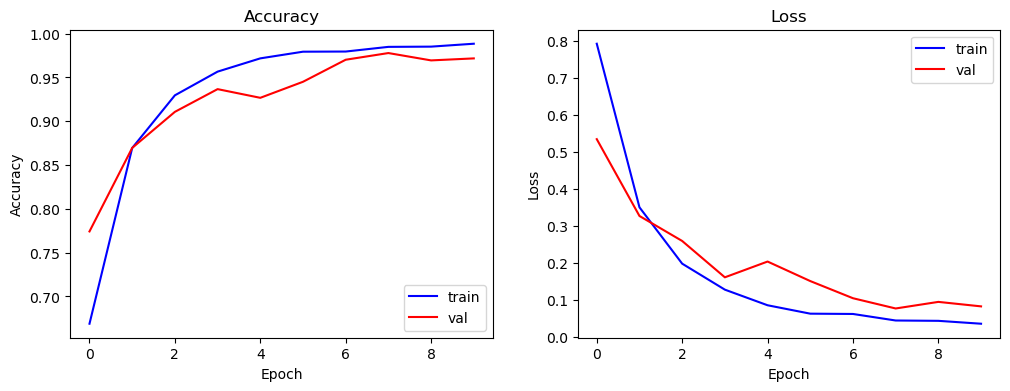

In [10]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(train_accuracy))
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(epochs, train_accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='lower right')
plt.subplot(1,2,2)
plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val'], loc='upper right')

11. Finally we plot the confusion matrix and F1-score of the model:

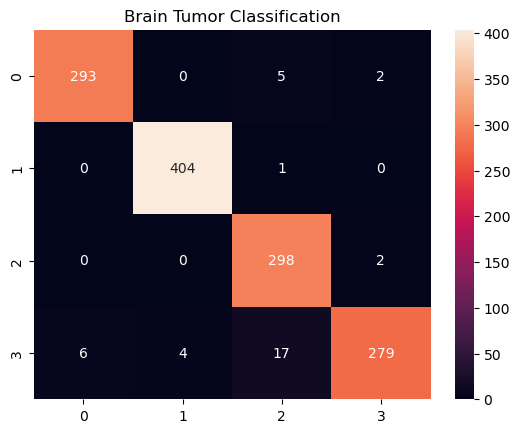

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       300
           1       0.99      1.00      0.99       405
           2       0.93      0.99      0.96       300
           3       0.99      0.91      0.95       306

    accuracy                           0.97      1311
   macro avg       0.97      0.97      0.97      1311
weighted avg       0.97      0.97      0.97      1311



In [11]:
confusion_matrix_result = confusion_matrix(y_test, y_pred2)
plt.title("Brain Tumor Classification")
ax = plt.subplot()
sns.heatmap(confusion_matrix_result, annot=True, fmt='g', ax=ax);
pl.show()
confusion_matrix = classification_report(y_test,y_pred2)
print(confusion_matrix)